<a href="https://colab.research.google.com/github/SilasEmma/CifarClassification/blob/main/CustomerChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Building Customer Churn prediction for Telecommunication Company.

# Every Company priority or dream is retaining existing customer which is more cost effective than acquiring new customers.
# Aim: building a classification algorithm that will help reduce customer churn also know as attrition.

In [2]:
# importing relevant libraries for building classification algorithm

# data manipulation, analysis and computation library
import pandas as pd
import numpy as np
# utility library
import io 
from google.colab import files
# data visualization library
import seaborn as sns
from matplotlib import pyplot as plt
# hyper-parameter turning and cross-validation library
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
# metrics and scoring 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_precision_recall_curve, plot_roc_curve
# model Algorithm 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 

%matplotlib inline

In [3]:
# uploading datasets to google colab
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [4]:
# convert to pandas Dataframe
cust = pd.read_csv(io.BytesIO(uploaded['WA_Fn-UseC_-Telco-Customer-Churn.csv']))

In [5]:
# return the first 5 head
cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# return the shape of dataframe. datasets consist of 7043 rows and 21 cols
cust.shape

(7043, 21)

In [7]:
# return the dtypes of each col. with categorical:18 int:2 and float:1
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
# return cols with missing values.
# observation: no col with missing value
cust.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# calculating number of customer that have churned and retained

retained = cust[cust.Churn == "No"]
churned = cust[cust.Churn == "Yes"]

print(f"Number of Customer's Retain {retained.shape[0]}")
print(f"Number of Customer's Churn {churned.shape[0]}")

print("")

# calculating the percentage
num_retain = retained.shape[0]
num_churn = churned.shape[0]

print(round(num_retain / (num_retain + num_churn) * 100),"% retained customer's")
print(round(num_churn / (num_churn + num_retain) * 100),"% churned customer's")

Number of Customer's Retain 5174
Number of Customer's Churn 1869

73 % retained customer's
27 % churned customer's


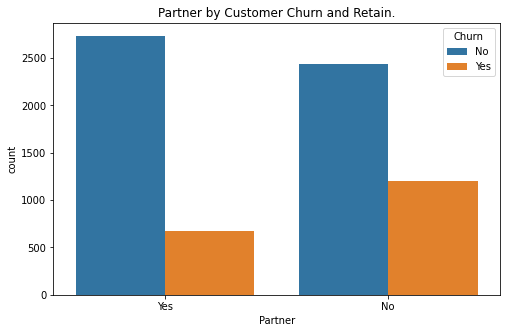

In [10]:
# Data Analysis and Insight using visualization tools
# Observation: customer's with partners are more liking to churn.

plt.figure(figsize=(8,5))

plt.title('Partner by Customer Churn and Retain.')
sns.countplot(x='Partner', hue='Churn', data=cust)

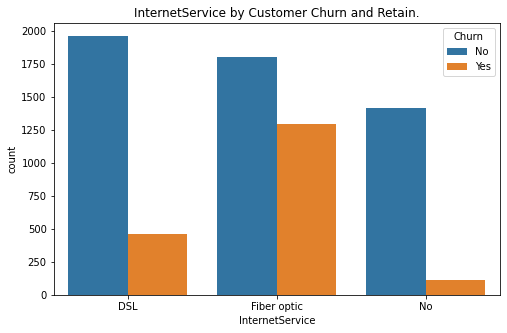

In [11]:
# Data Analysis and Insight using visualization tools
# Observation: customer's using Fiber-optic services are more liking to churn.

plt.figure(figsize=(8,5))

plt.title('InternetService by Customer Churn and Retain.')
sns.countplot(x='InternetService', hue='Churn', data=cust)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13a536d510>,
      dtype=object)

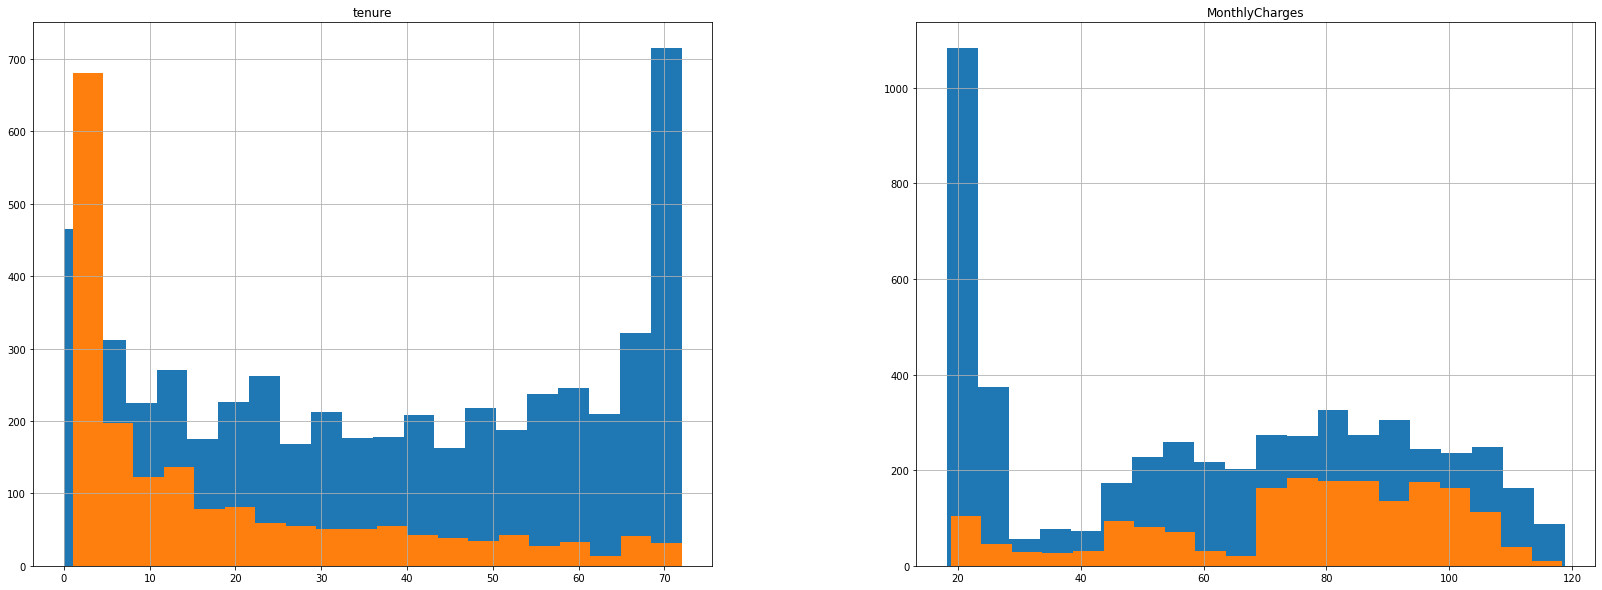

In [12]:
# Data Analysis and Insight using visualization tools
# Aim showing relationship between Tenure and MonthlyCharges
# Observation: customer's who churn in the first 2yrs was due to huge increase in monthlycharges.

show_churn = ['tenure', 'MonthlyCharges']
fig, ax = plt.subplots(1, 2, figsize=(28, 10))

cust[cust.Churn == "No"][show_churn].hist(bins=20, ax=ax)
cust[cust.Churn =="Yes"][show_churn].hist(bins=20, ax=ax)

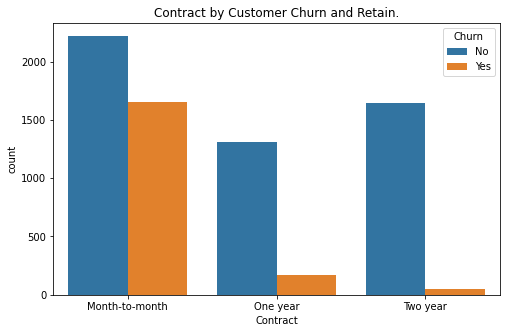

In [13]:
# Data Analysis and Insight using visualization tools
# Observation: customer's that signed for month-to-month are more liking to churn.

plt.figure(figsize=(8,5))

plt.title('Contract by Customer Churn and Retain.')
sns.countplot(x='Contract', hue='Churn', data=cust)

In [14]:
# Data preprocessing
# Using Sklearn library LabelEncoding to convert categorical cols in numerical, also known as OneHotEncoding.

# dropping inrelevant cols
clean_col = cust.drop(['customerID'], axis=1)

# preprocessing data
for column in clean_col:
  if clean_col[column].dtypes == np.number:
    continue
  clean_col[column] = LabelEncoder().fit_transform(clean_col[column])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if __name__ == '__main__':


In [15]:
# returns first five head of clean cols
clean_col.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1


In [16]:
# assign our parameters to X variable and values to predict to y variable
X = clean_col.drop(['Churn'], axis=1)
y = clean_col['Churn']

In [17]:
# Standardize features by removing the mean and scaling to unit variance
X = StandardScaler().fit_transform(X)

In [18]:
#Split arrays or matrices into random train and test subsets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

In [19]:
# linear model for classification
model = LogisticRegression(random_state=1234)

In [20]:
# Stratified K-Folds cross-validator
# split data in train/test sets. This cross-validation object is a variation of KFold that returns stratified folds.  
skfld = StratifiedKFold(n_splits=10, random_state=1234)

# specified parameter values for an estimator
para_grid = {
    'C' : list(range(1, 5)),
    'penalty' : ('l1', 'l2', 'elasticnet'),
    'solver' : ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'multi_class' : ('auto', 'ovr', 'multinomial')
}

# Hyper-Parameter Turning
# Exhaustive search over specified parameter values for an estimator
grid = GridSearchCV(model, param_grid=para_grid, cv=skfld).fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFa

In [21]:
# getting the best parameter
print(grid.best_params_)
print("")
# getting best score
print(grid.best_score_)

{'C': 1, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}

0.8032454361054766


In [22]:
# implementing logistic regression with the best parameter
lt = LogisticRegression(C=1, multi_class='auto', penalty='l1', solver='saga', random_state=1234)
lt.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1234, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# predicting
y_pred = lt.predict(x_test)

In [24]:
# Accuracy classification score.
print(accuracy_score(y_test, y_pred))
print('')
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(y_test, y_pred))
print('')
# Build a text report showing the main classification metrics
print(classification_report(y_test, y_pred))

0.8031235210601041

[[1397  166]
 [ 250  300]]

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1563
           1       0.64      0.55      0.59       550

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



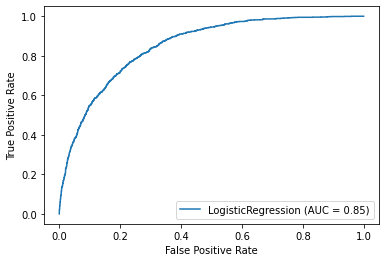

In [25]:
# Plot Receiver operating characteristic (ROC) curve.
plot_roc_curve(lt, x_train, y_train)

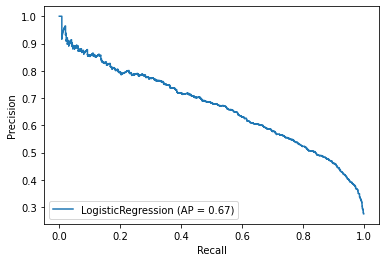

In [26]:
#Plot Precision Recall Curve for binary classifiers.
plot_precision_recall_curve(lt, x_train, y_train)

In [27]:
# Building Support Vector Machine 
S = clean_col.drop(['Churn'], axis=1)
Y = clean_col['Churn']

In [28]:
# This estimator scales and translates each feature individually such
# that it is in the given range on the training set, e.g. between
# zero and one.
S = MinMaxScaler().fit_transform(S)

In [29]:
# Split arrays or matrices into random train and test subsets
train_x, test_x, train_y, test_y = train_test_split(S, Y, test_size=0.30, random_state=1234)

In [30]:
# Support Vector Classification
svc = SVC(random_state=1234, probability=True, verbose=True)

In [32]:
# KFold Cross-Validation
# split data in train/test sets. Split dataset into k consecutive folds 
fld = StratifiedKFold(n_splits=10, shuffle=True)

# specified parameter values for an estimator
param_grd = {
    'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
    'gamma' : ('scale', 'auto'),
    'decision_function_shape' : ('ovo', 'ovr')
}

# Hyper-Parameter Turning
# Exhaustive search over specified parameter values for an estimator
gridcv = GridSearchCV(svc, param_grid=param_grd, cv=fld).fit(train_x, train_y)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [33]:
# getting the best parameter
print(gridcv.best_params_)
print("")
# getting best score
print(gridcv.best_score_)

{'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'sigmoid'}

0.8006085192697767


In [34]:
#
clf = SVC(gamma='auto', kernel='sigmoid', decision_function_shape='ovo', probability=True, verbose=True, random_state=1234)
clf.fit(train_x, train_y)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=True, random_state=1234, shrinking=True, tol=0.001,
    verbose=True)

In [35]:
# predicting
y_hat = clf.predict(test_x)

In [36]:
# Accuracy classification score.
print(accuracy_score(test_y, y_hat))
print('')
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(test_y, y_hat))
print('')
# Build a text report showing the main classification metrics
print(classification_report(test_y, y_hat))

0.8017037387600567

[[1407  156]
 [ 263  287]]

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1563
           1       0.65      0.52      0.58       550

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



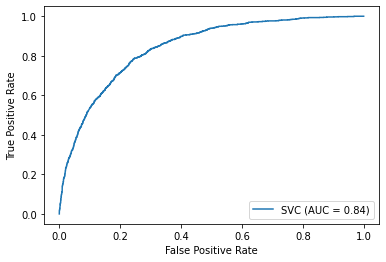

In [37]:
# Plot Receiver operating characteristic (ROC) curve.
plot_roc_curve(clf, train_x, train_y)

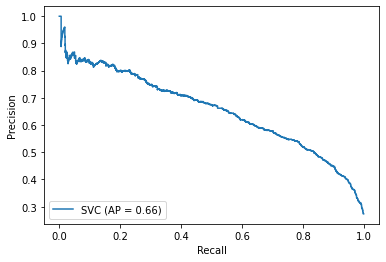

In [38]:
# Plot Precision Recall Curve for binary classifiers.
plot_precision_recall_curve(clf, train_x, train_y)